# <center> The Economic and Temperate Outlook of Africa based on Climate Change </center>
### <center> Spring 2024 Data Science Project </center>

**Link to GitHub**
https://github.com/ayomideadetunji/CMSC320spring2024Project

#####  By: Ayomide Adetunji, Imran Iro, Leul Mesfin, Moulaye Sy


##**1. Introduction**


We chose ten countries across the five regions in Africa (North, South, East, West, and Central) to determine the affect of climate change on GDP in Africa. We initially wanted to look at biodiversity, but it was difficult to find data that was consistent with our climate dataset. With the data that we were able to gather, we wanted to create a model that would accurately approximate the GDP of an African country based on its average annual temperature. This is important since the increase in climate as years go on could have a negative effect on the GDP of African countries. This leads us to our research question:

**Research Question:** *How does temperature affect the GDP of African economies.*

The features of our datasets were:
1. Annual precipitation
2. Monthly average temperature
3. Temperature anomalies
4. Monthly historical averages
5. Monthly max/min temperatures
6. Monthly historical max/min temperatures

None of the features were overrepresented and helped us draw conclusions to our answers

The three statistical methods we chose to view for each country were:
1. Mean temperature
2. Correlation between temperature/GDP and precipiation/GDP using Pearson's correlation coefficient
3. Chi-squared test to view the relationship between high temperatures and the GDP

Sources for our data:
- Climate Observer | Africa Data Hub. https://www.africadatahub.org/data-resources/climate-observer. Accessed 7 May 2024.
- “World Bank Open Data.” World Bank Open Data, https://data.worldbank.org/. Accessed 7 May 2024.

### **Contributions:**

Ayomide Adetunji: Contributed on all fronts, but uniquely created the GitHub pages and text configuration

Imran Iro: Contributed on all fronts, but uniquely selected the new idea after we faced issues with our first one (post-checkpoint 1)

Leul Mesfin: Contributed on all fronts, but uniquely contributed to dataset cleanup (choosing appropriate countries, converting types, etc.)

Moulaye Sy: Contributed on all fronts, but uniquely contributed to correlating data after the cleanup (crosstab)

###**Contribution Checkpoints:**

A: Project idea - 5%
B: Dataset Curation and Preprocessing - 10%
C: Data Exploration and Summary Statistics - 10%
D: ML Algorithm Design/Development - 25%
E: ML Algorithm Training and Test Data Analysis - 20%
F: Visualization, Result Analysis, Conclusion - 15%
G: Final Tutorial Report Creation - 10%

For example:

Member 1: Ayomide Adetunji, Contribution: 100%

Member 2: Imran Iro, Contribution: 100%

Member 3: Leul Mesfin, Contribution: 100%

Member 4: Moulaye Sy, Contribution: 100%

"We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial."  — AYOMIDE ADETUNJI, IMRAN IRO, LEUL MESFIN, MOULAYE SY

## **2. Data cleaning + Data storage of our climate and GDP datasets**

**Before getting into any code, here are the libraries that we will be using in the code blocks below**:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os
import scipy.stats as spstats
from google.colab import drive

We started off by cleaning our data for the climate. We had to use median imputation to find the data for max and min temperatures of each country, as well as the historical max and mix temperatures of each country.


In [ ]:
drive.mount('/content/drive')

%cd /content/drive/MyDrive/320_final_datasets

def celcius_to_fahrenheit(temp):
  return (9/5) * int(temp) + 32

country_dataframes = {}
countries = ['DRC', 'Egypt', 'Ethiopia', 'Kenya', 'Morocco', 'Nigeria', 'Senegal', 'South_Africa', 'Sudan', 'Zimbabwe']

# Creating a dictionary of country_dataframes for each country containing each country's average monthly temp/temp anomalies and precipiation
for country in countries:

    avg_monthly_temp_df, avg_monthy_precip_df, temp_anomalies = pd.read_csv(f'{country}/avg_monthly_temp_{country.lower()}_1993-2023.csv'), \
                                                 pd.read_csv(f'{country}/avg_monthly_precip_{country.lower()}_1993-2023.csv').drop(['Year', 'Month'], axis=1), \
                                                 pd.read_csv(f'{country}/temp_anomalies_{country.lower()}_1993-2023.csv').drop(['Year', 'Month'], axis=1)

    dec_median_hist_max_temp = avg_monthly_temp_df["Historical Max"][(avg_monthly_temp_df['Month'] == 'December')
                                                                          & (avg_monthly_temp_df['Year'] != 2023)].median()
    dec_median_hist_min_temp = avg_monthly_temp_df["Historical Min"][(avg_monthly_temp_df['Month'] == 'December')
                                                                          & (avg_monthly_temp_df['Year'] != 2023)].median()
    dec_median_max_temp = avg_monthly_temp_df["Max Temperature"][(avg_monthly_temp_df['Month'] == 'December')
                                                                          & (avg_monthly_temp_df['Year'] != 2023)].median()
    dec_median_min_temp = avg_monthly_temp_df["Min Temperature"][(avg_monthly_temp_df['Month'] == 'December')
                                                                          & (avg_monthly_temp_df['Year'] != 2023)].median()

    # Impute the missing values for December 2023
    avg_monthly_temp_df.loc[(avg_monthly_temp_df['Month'] == 'December') & (avg_monthly_temp_df['Year'] == 2023), 'Historical Max'] = dec_median_hist_max_temp
    avg_monthly_temp_df.loc[(avg_monthly_temp_df['Month'] == 'December') & (avg_monthly_temp_df['Year'] == 2023), 'Historical Min'] = dec_median_hist_min_temp
    avg_monthly_temp_df.loc[(avg_monthly_temp_df['Month'] == 'December') & (avg_monthly_temp_df['Year'] == 2023), 'Max Temperature'] = dec_median_max_temp
    avg_monthly_temp_df.loc[(avg_monthly_temp_df['Month'] == 'December') & (avg_monthly_temp_df['Year'] == 2023), 'Min Temperature'] = dec_median_min_temp

    avg_monthly_temp_df['Average Temperature'] = avg_monthly_temp_df['Average Temperature'].apply(celcius_to_fahrenheit)
    avg_monthly_temp_df['Historical Average'] = avg_monthly_temp_df['Historical Average'].apply(celcius_to_fahrenheit)
    avg_monthly_temp_df['Max Temperature'] = avg_monthly_temp_df['Max Temperature'].apply(celcius_to_fahrenheit)
    avg_monthly_temp_df['Min Temperature'] = avg_monthly_temp_df['Min Temperature'].apply(celcius_to_fahrenheit)
    avg_monthly_temp_df['Historical Max'] = avg_monthly_temp_df['Historical Max'].apply(celcius_to_fahrenheit)
    avg_monthly_temp_df['Historical Min'] = avg_monthly_temp_df['Historical Min'].apply(celcius_to_fahrenheit)

    country_dataframes[country] = pd.concat([avg_monthly_temp_df, avg_monthy_precip_df, temp_anomalies], axis=1)
    #display(country_dataframes['DRC'])

print(country_dataframes.items())

gdp_df = pd.read_csv('annual_gdp_1993-2023.csv')

## printing out the climate dataset
# pd.set_option('expand_frame_repr', False)

Mounted at /content/drive
/content/drive/MyDrive/320_final_datasets
dict_items([('DRC',          Month  Year  Average Temperature  Historical Average  \
0      January  1993                 75.2                75.2   
1     February  1993                 75.2                75.2   
2        March  1993                 75.2                75.2   
3        April  1993                 77.0                75.2   
4          May  1993                 77.0                75.2   
..         ...   ...                  ...                 ...   
367     August  2023                 77.0                73.4   
368  September  2023                 77.0                75.2   
369    October  2023                 77.0                75.2   
370   November  2023                 77.0                75.2   
371   December  2023                 77.0                75.2   

     Max Temperature  Min Temperature  Historical Max  Historical Min  \
0               86.0             64.4            86.0     

##**3. Exploratory data analysis**


###Graphical Representation of The Change of Annual Temperature Over Time for Various Countries (1993 - 2023)

Our observation was that the average yearly temperatures of each country did typically get higher by a few degrees between 1993 and 2023. The range of average temperatures was typically between 3 degrees

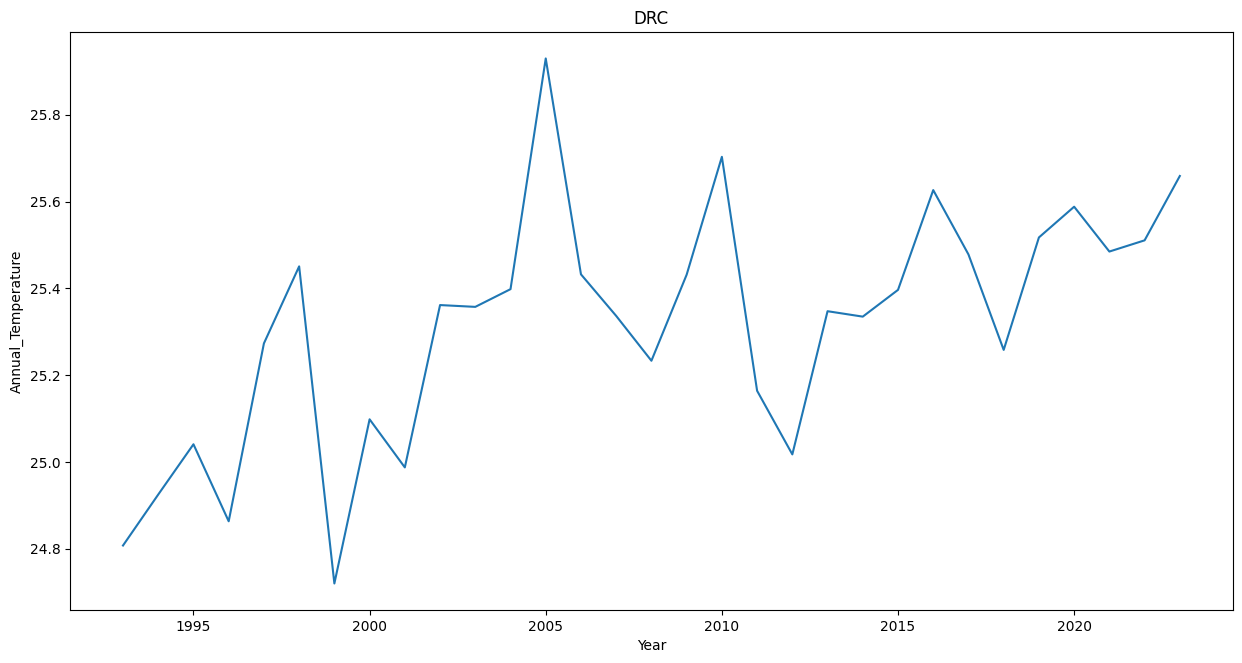

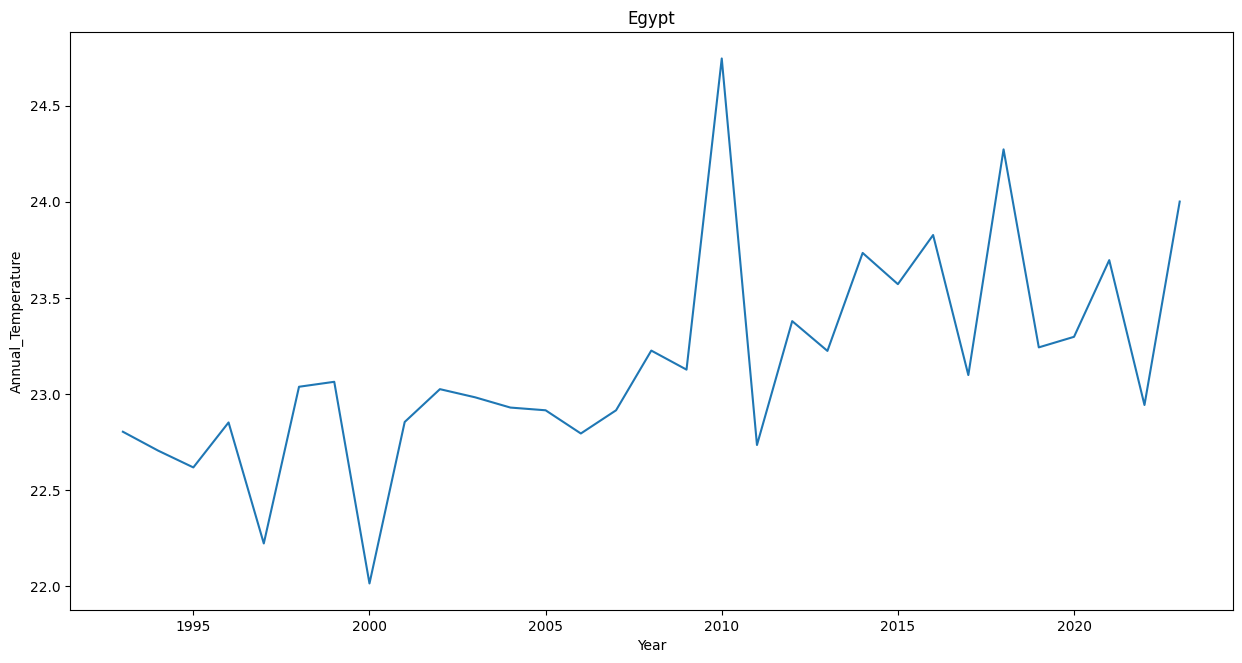

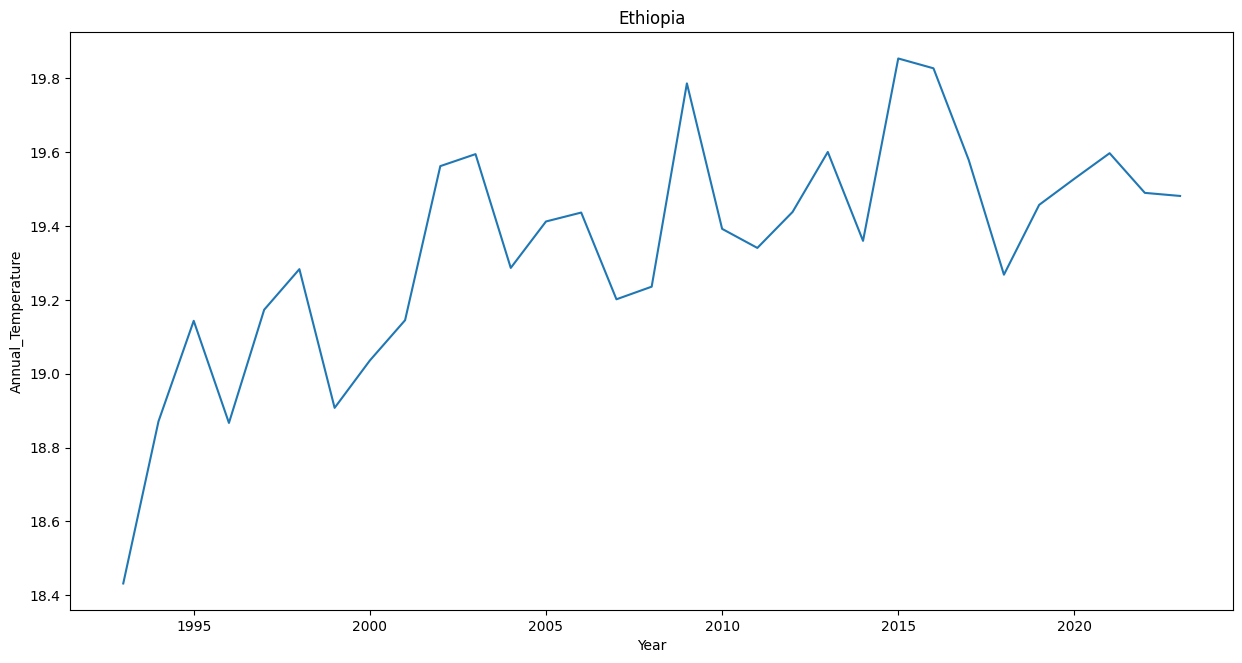

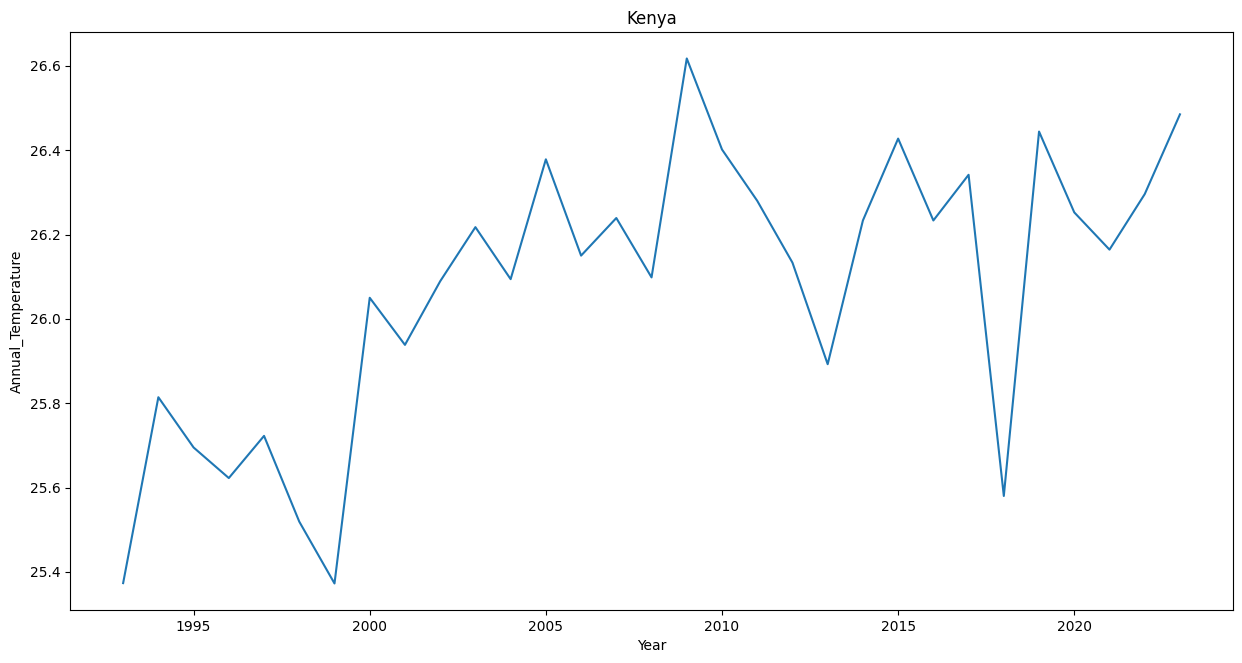

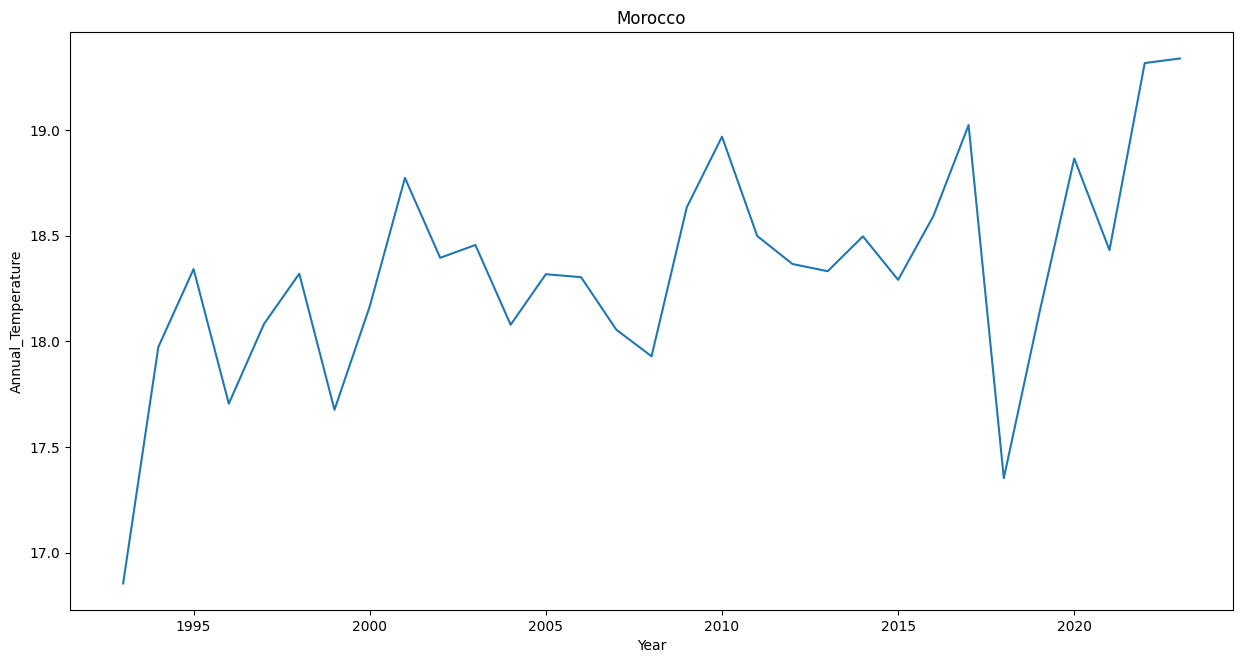

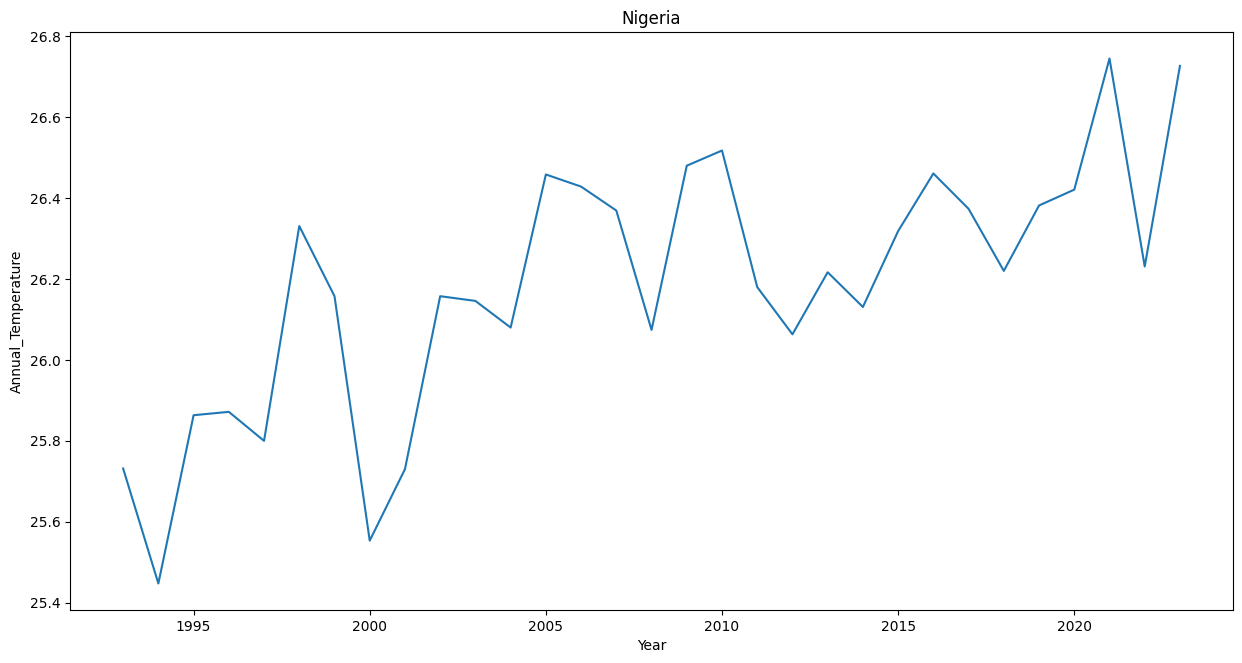

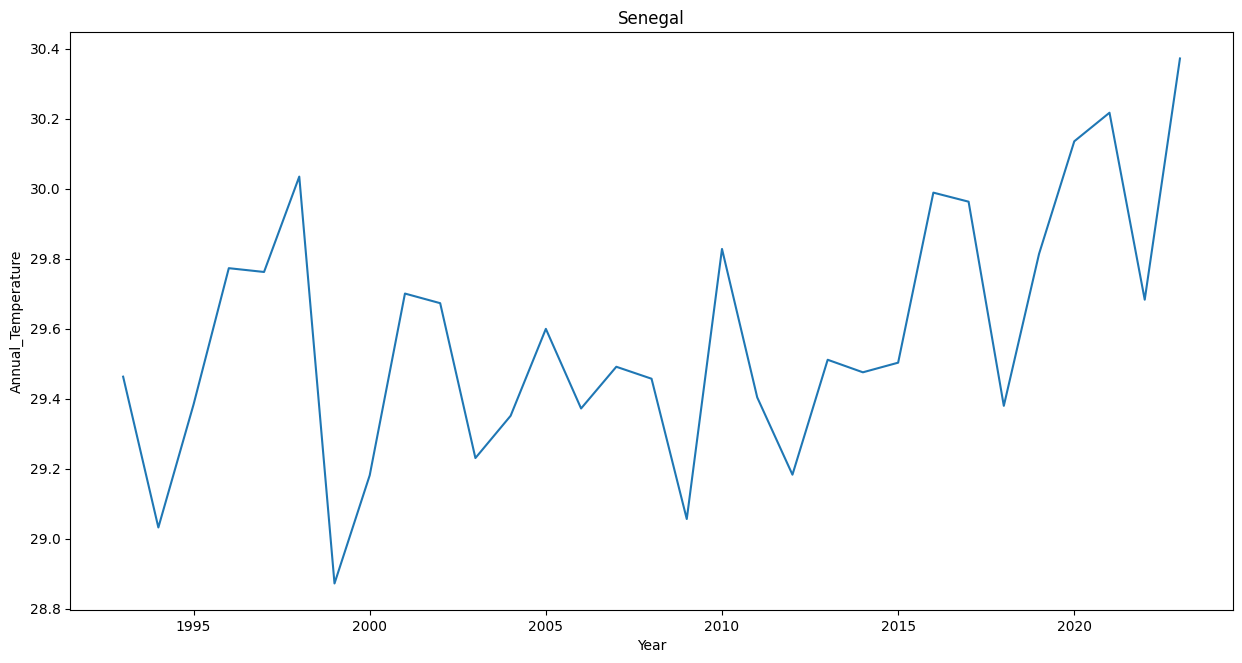

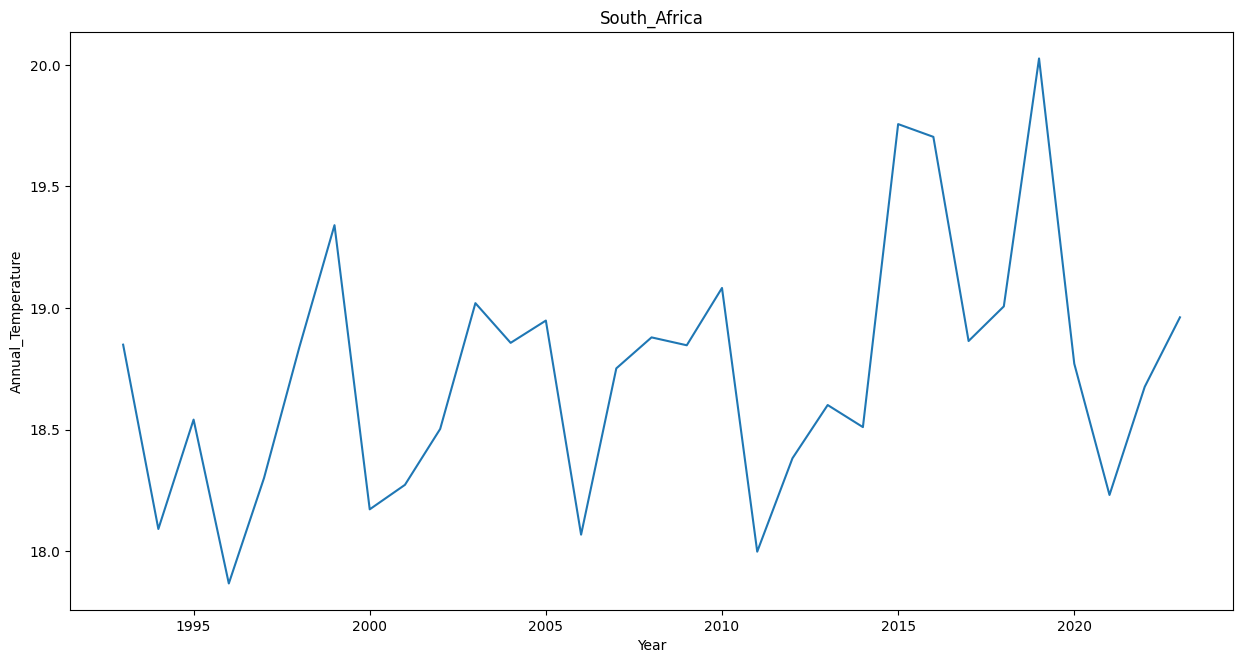

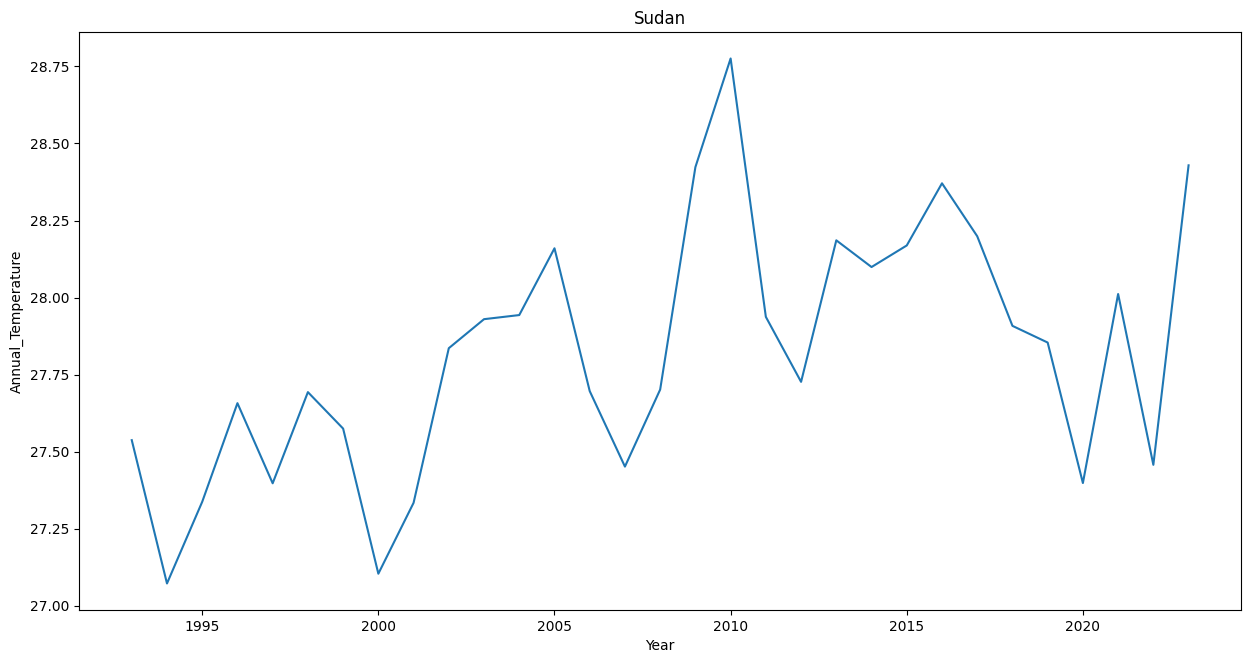

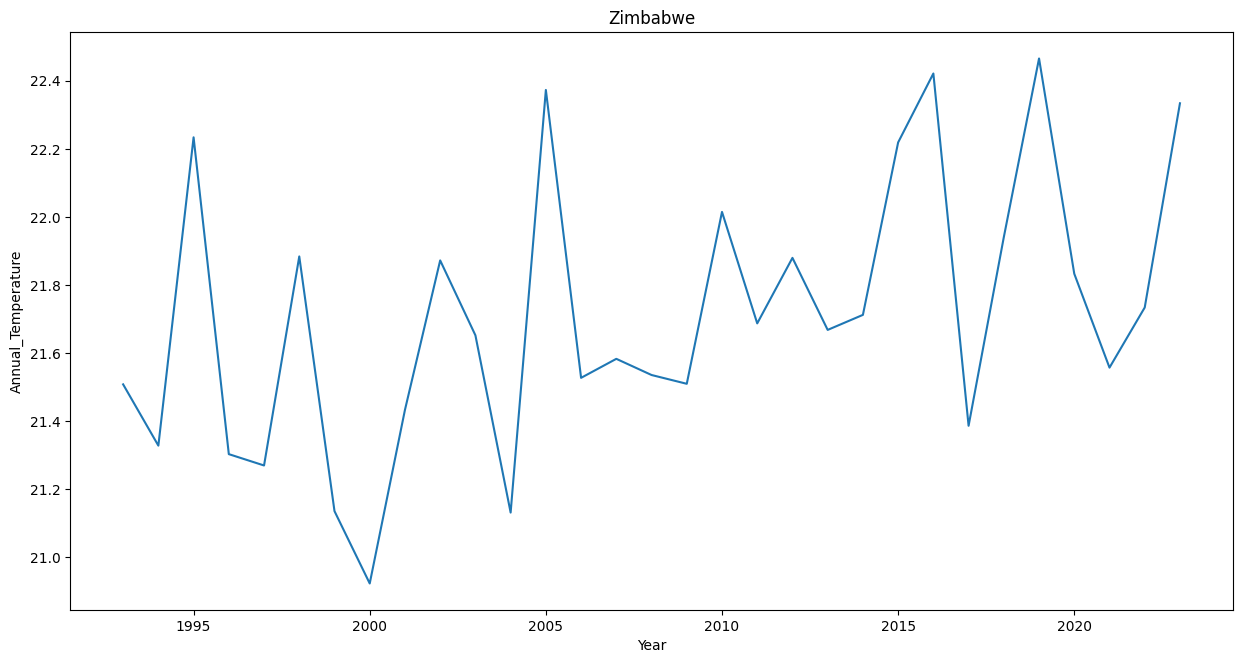

In [ ]:
def plot_graph(df):
    xs = df['Year']
    ys = df['Annual_Temperature']
    plt.plot(xs, ys)

for country in country_dataframes:
  precip_data = pd.read_csv(f'{country}/avg_monthly_precip_{country.lower()}_1993-2023.csv')
  temp_data = pd.read_csv(f'{country}/avg_monthly_temp_{country.lower()}_1993-2023.csv')

  # didn't know which data point we wanted to track so we just got the GDP, annual precip, and annual average temp
  data = pd.DataFrame({'Year': range(1993, 2024),
                      'GDP': gdp_df.loc[gdp_df['Country Name'] == country, '1993':].values[0],
                      'Annual_Precipitation': precip_data.groupby('Year')['Precipitation'].sum().values,
                      'Annual_Temperature': temp_data.groupby('Year')['Average Temperature'].mean().values})
  # display(data)
  fig, plot = plt.subplots(figsize=(15, 7.5))
  df_sorted = data.sort_values('Year', ascending=True)
  plot_graph(df_sorted)

  plt.title(country)
  plt.xlabel('Year')
  plt.ylabel('Annual_Temperature')

###Graphical Representation of Pearson Coefficient Test for correlation between GDP and Climate + Correlation between GDP and Precipitation (1993 - 2023)**


Our observation was that there was a positive weak correlation between annual precipitation and GDP, while the average temperature and GDP were typically very weakly negatively correlated

Correlation between GDP of DRC and Annual Precipitation of DRC: r = -0.5852966882113358, p-value = 0.0005427828632713242
Correlation between GDP of DRC and Annual Temperature of DRC: r = 0.4688626801079422, p-value = 0.007800686444235777 



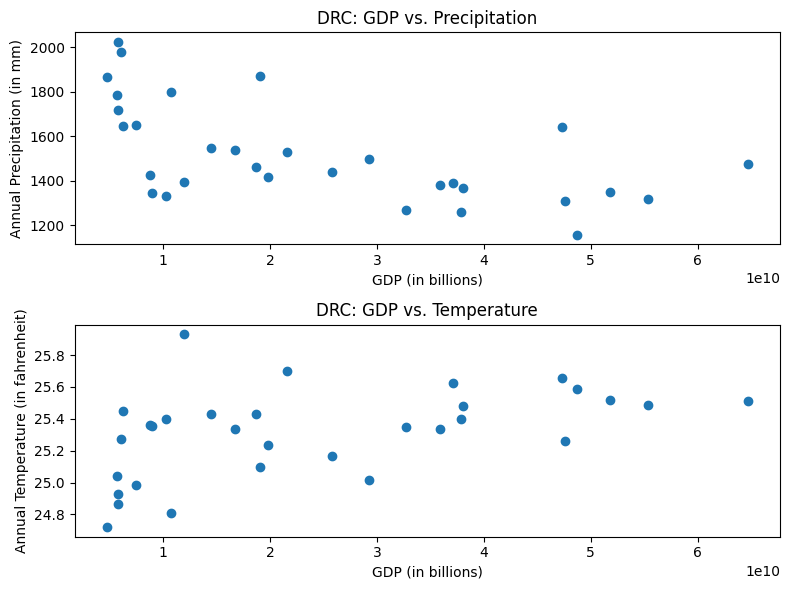


Correlation between GDP of Egypt and Annual Precipitation of Egypt: r = 0.16996249818490286, p-value = 0.3606650441640522
Correlation between GDP of Egypt and Annual Temperature of Egypt: r = 0.5516465274266414, p-value = 0.0012958135861010085 



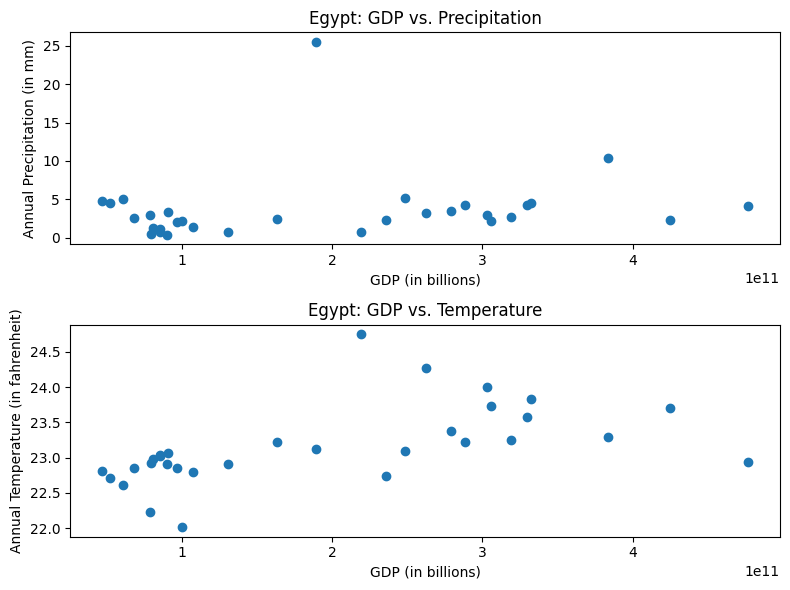


Correlation between GDP of Ethiopia and Annual Precipitation of Ethiopia: r = -0.12023654982983863, p-value = 0.5193924730554937
Correlation between GDP of Ethiopia and Annual Temperature of Ethiopia: r = 0.5184370273751584, p-value = 0.0028098643114017234 



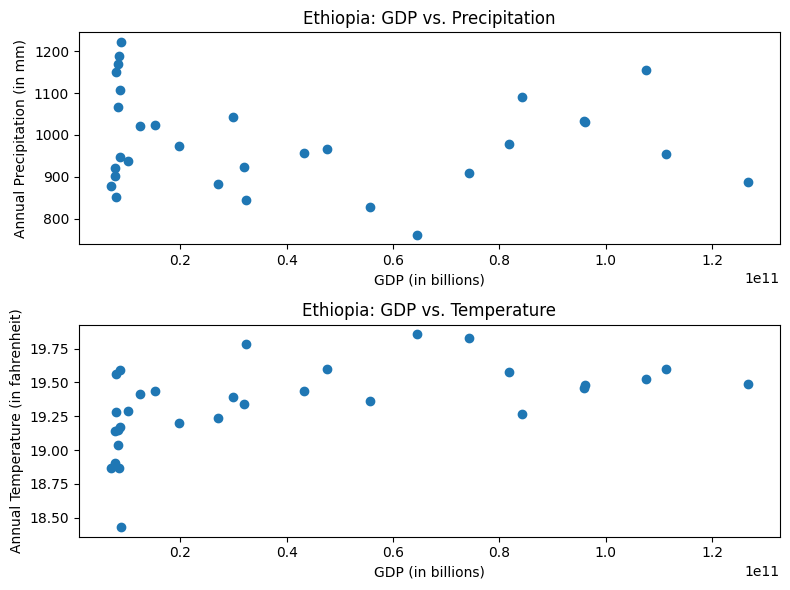


Correlation between GDP of Kenya and Annual Precipitation of Kenya: r = -0.015025665210641907, p-value = 0.93605766203146
Correlation between GDP of Kenya and Annual Temperature of Kenya: r = 0.49582778993747056, p-value = 0.004560322370561173 



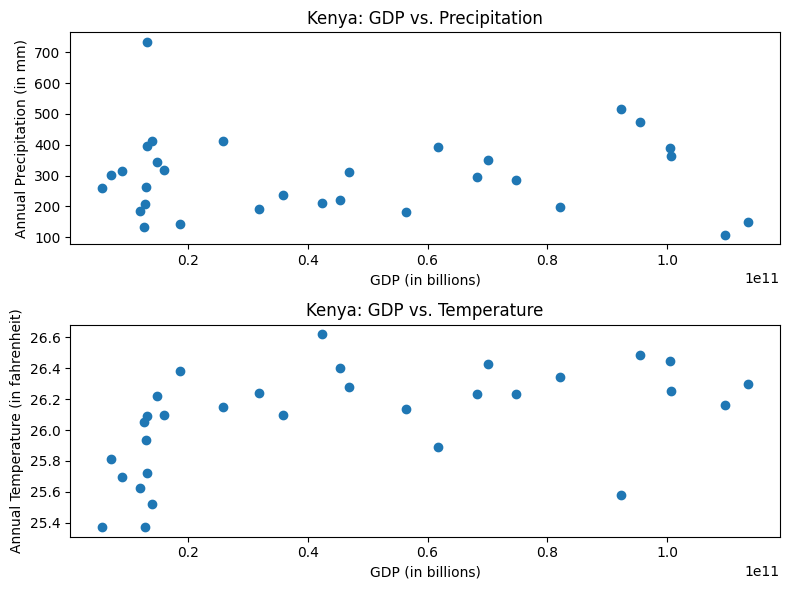


Correlation between GDP of Morocco and Annual Precipitation of Morocco: r = -0.10849460334305132, p-value = 0.5612621611350899
Correlation between GDP of Morocco and Annual Temperature of Morocco: r = 0.4449965014018419, p-value = 0.0121270344656369 



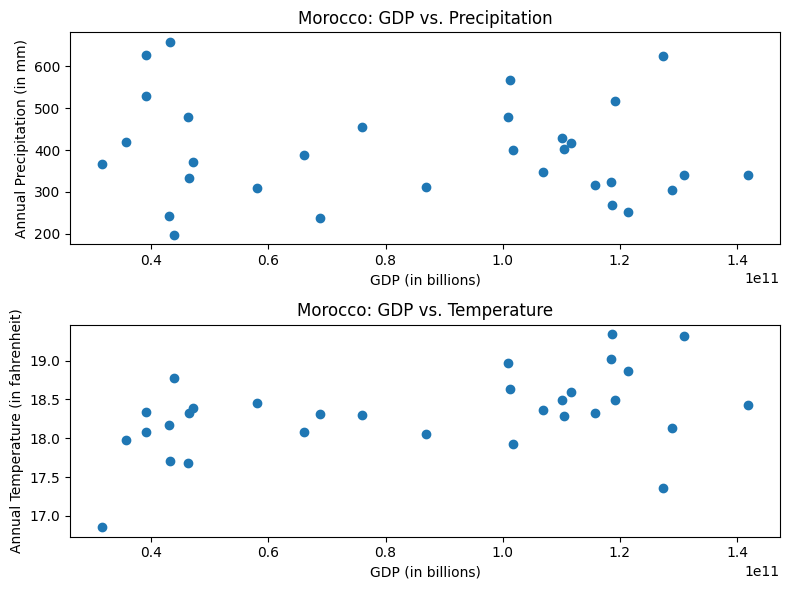


Correlation between GDP of Nigeria and Annual Precipitation of Nigeria: r = -0.2672253476281472, p-value = 0.1461442252717352
Correlation between GDP of Nigeria and Annual Temperature of Nigeria: r = 0.5885296117659021, p-value = 0.000496745334989415 



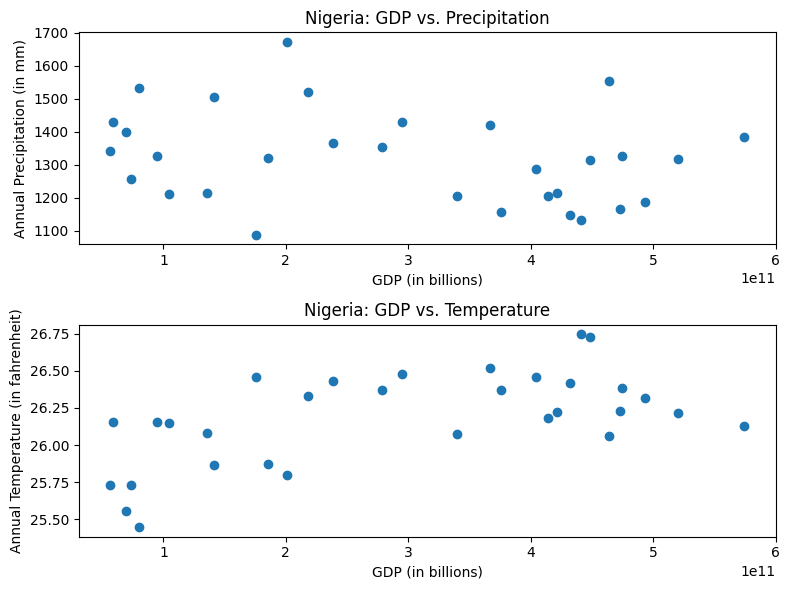


Correlation between GDP of Senegal and Annual Precipitation of Senegal: r = 0.063773992251931, p-value = 0.7332284701194886
Correlation between GDP of Senegal and Annual Temperature of Senegal: r = 0.4533546725855606, p-value = 0.010426654141845062 



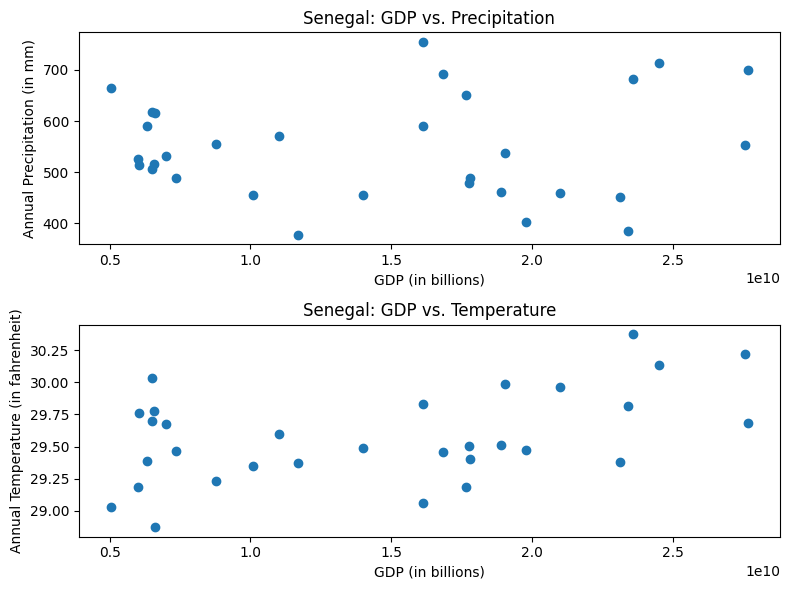


Correlation between GDP of South_Africa and Annual Precipitation of South_Africa: r = -0.10384798570798416, p-value = 0.5782469597244508
Correlation between GDP of South_Africa and Annual Temperature of South_Africa: r = 0.2089305561265993, p-value = 0.2593299831835401 



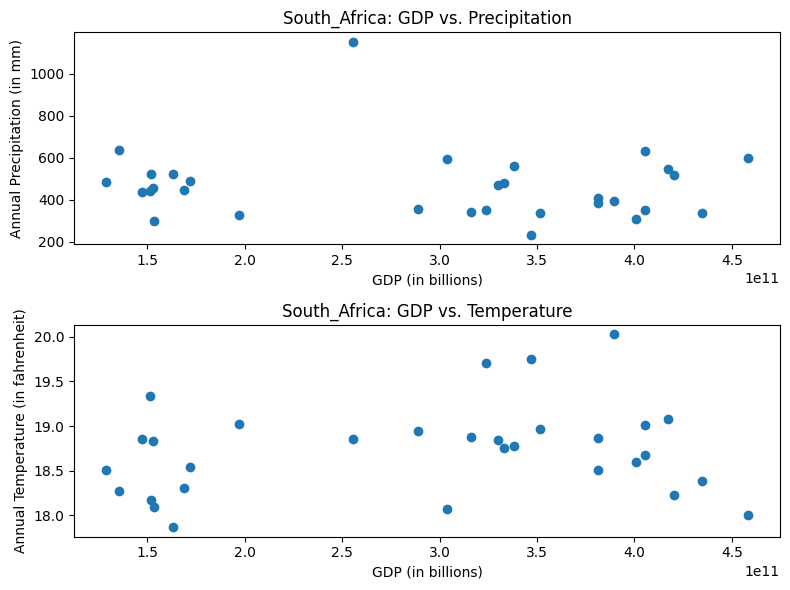


Correlation between GDP of Sudan and Annual Precipitation of Sudan: r = -0.4340977112227097, p-value = 0.014688332885090218
Correlation between GDP of Sudan and Annual Temperature of Sudan: r = 0.5749735463522859, p-value = 0.0007159537345301162 



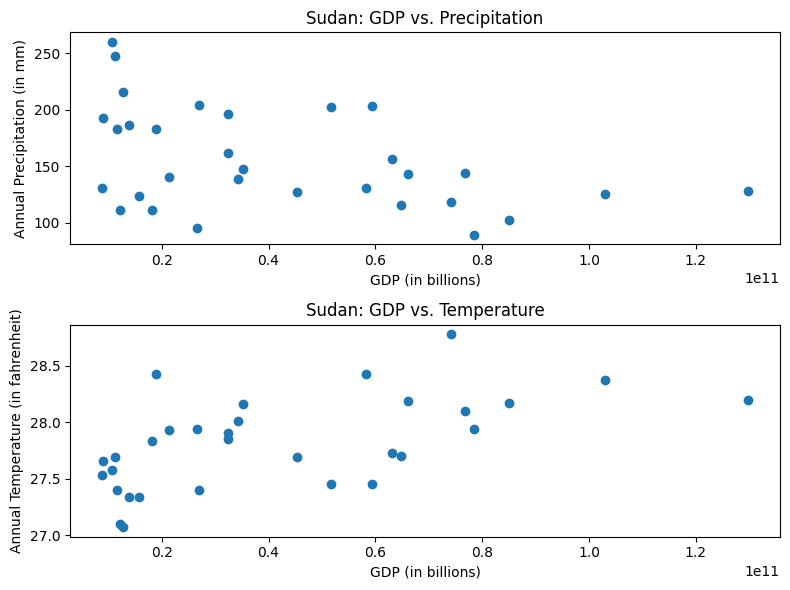


Correlation between GDP of Zimbabwe and Annual Precipitation of Zimbabwe: r = -0.2340645693848567, p-value = 0.20502853237652482
Correlation between GDP of Zimbabwe and Annual Temperature of Zimbabwe: r = 0.401523364978714, p-value = 0.025163693804058907 



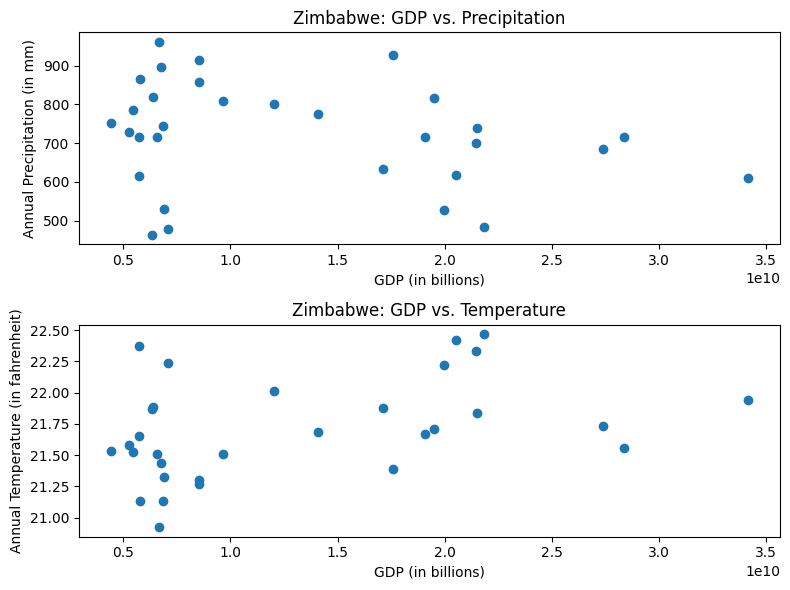

In [ ]:
for country in country_dataframes:

  precip_data = pd.read_csv(f'{country}/avg_monthly_precip_{country.lower()}_1993-2023.csv')
  temp_data = pd.read_csv(f'{country}/avg_monthly_temp_{country.lower()}_1993-2023.csv')

  ## Data Prep
  gdp = gdp_df.loc[gdp_df['Country Name'] == country, '1993':].values.flatten()
  annual_precip = precip_data.groupby('Year')['Precipitation'].sum().values
  annual_temp = temp_data.groupby('Year')['Average Temperature'].mean().values

  ## Pearson's correlation coefficient test
  corr, p_val = spstats.pearsonr(gdp, annual_precip)
  print(f"Correlation between GDP of {country} and Annual Precipitation of {country}: r = {corr}, p-value = {p_val}")

  corr, p_val = spstats.pearsonr(gdp, annual_temp)
  print(f"Correlation between GDP of {country} and Annual Temperature of {country}: r = {corr}, p-value = {p_val} \n")

  fig, (plot1, plot2) = plt.subplots(nrows=2, figsize=(8, 6))

  ## GDP v. PRECIPITATION PLOT
  plot1.scatter(gdp, annual_precip)
  plot1.set_xlabel('GDP (in billions)')
  plot1.set_ylabel('Annual Precipitation (in mm)')
  plot1.set_title(f'{country}: GDP vs. Precipitation')

  ## GDP v. TEMPERATURE PLOT
  plot2.scatter(gdp, annual_temp)
  plot2.set_xlabel('GDP (in billions)')
  plot2.set_ylabel('Annual Temperature (in fahrenheit)')
  plot2.set_title(f'{country}: GDP vs. Temperature')

  ## Space between each plot
  plt.tight_layout()
  plt.show()
  print('=' * 125 + '\n' )





###Graphical relationship between high temperatures and GDP**


High temperatures are temperatures that were categorized as above the median for each year in each country. We intended on using a chi-squared test to do this, but we found difficulties in using the crosstab function to create a contingency table to show the relationship between GDP and temperatures that were high

In [ ]:
# median of temperatures is threshold
# 0 is low, 1 is high (Leul added 05/5/24)
def temp_category(temp):
  if (temp < country_df.groupby('Year')['Average Temperature'].median().iloc[1]):
    #return 'low'
    return 0
  else:
    #return 'high'
    return 1

for country in countries:
  country_df = country_dataframes[country]
  country_df.dtypes
  country_df['Temperature Intensity'] = country_df['Average Temperature'].apply(temp_category)

In [ ]:
# Goal: crosstab every country's yearly_temp_intensity_df with the GDP
for country in countries:
  country_df = country_dataframes[country]
  yearly_temp_intensity_df = pd.DataFrame({'Year': range(1993, 2024)})

  def yearTempMode(year):
    return country_df[country_df['Year'] == year]['Temperature Intensity'].mode()[0]

  yearly_temp_intensity_df['Temperature Intensity'] = yearly_temp_intensity_df['Year'].apply(yearTempMode)
  cross_ready_gdp = pd.DataFrame({'Year': range(1993, 2024)})

# print(yearly_temp_intensity_df)
print(yearly_temp_intensity_df.to_string(index=False), end=' ')

 Year  Temperature Intensity
 1993                      1
 1994                      1
 1995                      1
 1996                      1
 1997                      0
 1998                      1
 1999                      0
 2000                      1
 2001                      1
 2002                      1
 2003                      1
 2004                      0
 2005                      1
 2006                      0
 2007                      1
 2008                      1
 2009                      1
 2010                      1
 2011                      1
 2012                      1
 2013                      1
 2014                      1
 2015                      1
 2016                      1
 2017                      1
 2018                      1
 2019                      1
 2020                      1
 2021                      1
 2022                      1
 2023                      1 

,Year,Temperature Intensity,GDP
0,1993,1,6563813300
1,1994,1,6890675000
2,1995,1,7111270700
3,1996,1,8553146600
4,1997,0,8529571600
5,1998,1,6401968200
6,1999,0,6858013100
7,2000,1,6689957600
8,2001,1,6777384700
9,2002,1,6342116400


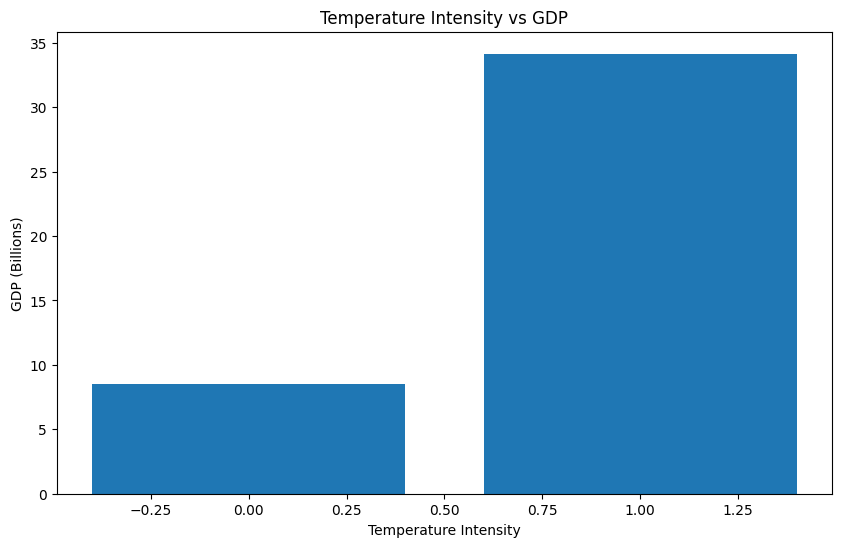

In [50]:
new_df =  gdp_df[gdp_df['Country Name'] == country].drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis = 1).transpose()
new_df.index.name = 'Year'
new_df.index = new_df.index.astype(int)

# I found that I cound rename the indices (matching with the index from the OG GDP) pretty nicely
# here. This is good stuff.
new_df.rename(columns = {gdp_df[gdp_df['Country Name'] == country].index[0]:'GDP'}, inplace = True)

# gdp table
merged_df = pd.merge(cross_ready_gdp, new_df, left_on='Year', right_index=True)

# final step: merge gdp and temp intensity into one table
crosstab = pd.merge(yearly_temp_intensity_df, merged_df, on='Year')
display(crosstab)

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(crosstab['Temperature Intensity'], crosstab['GDP']/1e9)
ax.set_xlabel('Temperature Intensity')
ax.set_ylabel('GDP (Billions)')
ax.set_title('Temperature Intensity vs GDP')
# plt.bar(crosstab['Temperature Intensity'], crosstab['GDP'])
plt.show()

##**4. Primary Analysis**

Based on our observations, we know that temperature can be represented as continuous data. We also hypothesize that if we train a model on our data, we should be able to guess the economic outlook (in terms of GDP) of an African country based on its temperature. Therefore, we have decided to go with using a neural network to achieve this.

##**5. Visualization**

We'll be using machine learning to train our model  to draw conclusions between climate change around Africa on the GDPs around Africa. Since we have access to data such as the average annual climate, temperature anomalies, and etc, we will need multiple models to draw a conclusion on all of our data

In [ ]:
X = []
y = []

# since our dataframes are stored in a dictionary of countries, we have to iterate
# through each key and process the dataframes individually, then finally concatenate
# the temperature and all that good stuff
for key in country_dataframes:
    country_df = country_dataframes[key]
    gdp_data = gdp_df[gdp_df['Country Name'] == key]
    gdp_data = gdp_data.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                             var_name='Year', value_name='GDP (current US$)')
    gdp_data['Year'] = gdp_data['Year'].astype(int)
    merged_df = pd.merge(country_df, gdp_data, on='Year').dropna()
    X.append(merged_df['Average Temperature'].values.reshape(-1, 1))
    y.append(merged_df['GDP (current US$)'].values.reshape(-1, 1))

# concatenating the columns in the dataframes
X = np.concatenate(X)
y = np.concatenate(y)

scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# train/test splitting
test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=seed)

Now we can prepare the neural network

In [ ]:
# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

class GDPModel(nn.Module):
    def __init__(self):
        super(GDPModel, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model = GDPModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 500
batch_size = 64

# learning rate scheduler to reduce learning rate by factor=0.1 after every 10 epochs after loss doesn't increase
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_losses = []
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i : i + batch_size]
        batch_y = y_train[i : i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the training loss for every 50 epochs
    train_losses.append(loss.item())
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Update the learning rate
    scheduler.step(loss)

with torch.no_grad():
    y_pred = model(X_test)

# Convert tensors to numpy arrays for evaluation and plotting
y_test = y_test.numpy()
y_pred = y_pred.numpy()

Epoch [50/500], Loss: 1.0702
Epoch [100/500], Loss: 1.0820
Epoch [150/500], Loss: 1.0109
Epoch [200/500], Loss: 1.0846
Epoch [250/500], Loss: 1.0329
Epoch [300/500], Loss: 1.0769
Epoch [350/500], Loss: 1.0663
Epoch [400/500], Loss: 1.1563
Epoch [450/500], Loss: 1.0872
Epoch [500/500], Loss: 1.1002


Evaluating the models performance, using R2 score and MSE, as well as plotting the loss over time of each epoch

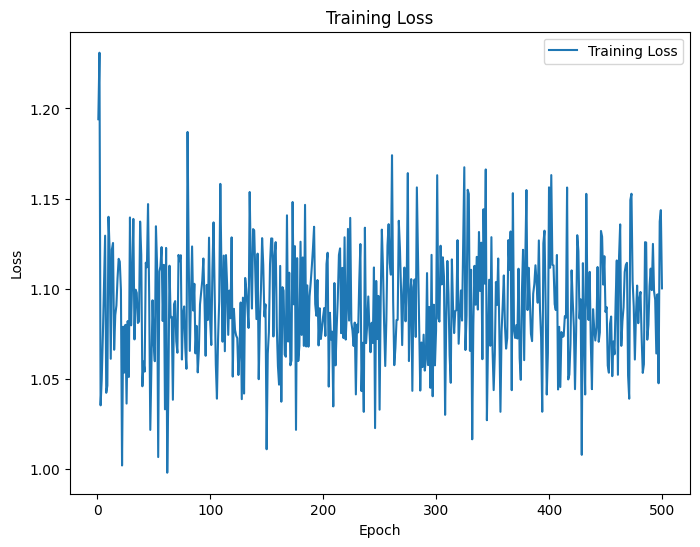

In [ ]:
# time to evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

The r2 is very close to 0, and the MSE is extremely high, which means our model is not very accurate. On the other hand, our loss isn't the worst, and it does somewhat decrease over time. We've done dozens of iterations of our neural network, but often times we found that the model tended to underfit since our data was a bit sparse. This is something that we did not forsee when we first picked our datasets, but in retrospect, we definitely should have used more countries from Africa (at least 40).

Now that we've prepared the model, we can use test data and see what the model outputs when we input some randomly picked temperature values:

In [ ]:
# Prepare the input data for prediction
new_data = np.array([[25.5], [26.8], [24.2]])  # Example temperature values

# Scale the input data
new_data_scaled = scaler_x.transform(new_data)

# Convert the input data to a PyTorch tensor
new_data_tensor = torch.from_numpy(new_data_scaled).float()

# Set the model to evaluation mode
model.eval()

GDPModel(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Now we can do the actual predictions:

In [ ]:
# Make predictions using the trained model
with torch.no_grad():
    predicted_gdp_scaled = model(new_data_tensor)

# Convert the predicted GDP tensor to a numpy array
predicted_gdp_scaled = predicted_gdp_scaled.numpy()

# Inverse-transform the predicted GDP values
predicted_gdp = scaler_y.inverse_transform(predicted_gdp_scaled)

# Print the predicted GDP values
for i in range(len(new_data)):
    print(f"Temperature: {new_data[i][0]:.1f}, Predicted GDP: {predicted_gdp[i][0]:.2f}")

Temperature: 25.5, Predicted GDP: 265685811200.00
Temperature: 26.8, Predicted GDP: 260309106688.00
Temperature: 24.2, Predicted GDP: 271063203840.00


Is this accurate? Quite honestly, probably not. Our model had a relatively high loss

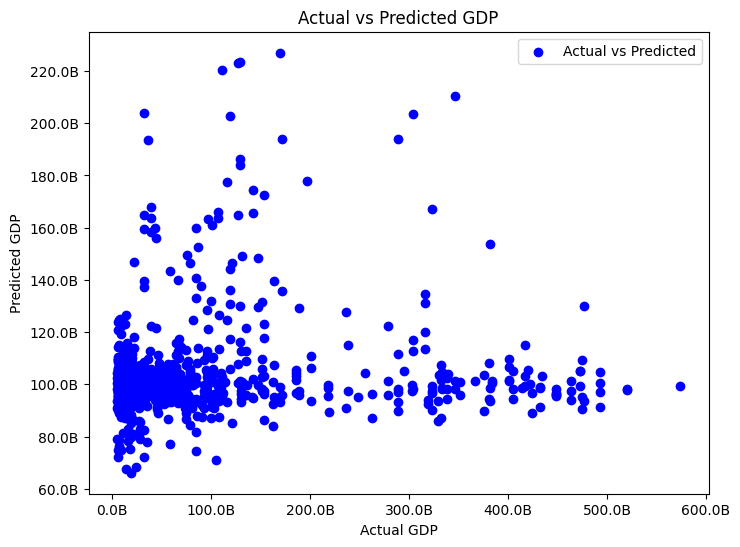

In [ ]:
# ngl we used chatgpt for this part because the x and y axes were going whammy
# Define a function to format the tick labels
def format_billions(x, pos):
    return f'{x / 1e9:.1f}B'

formatter = ticker.FuncFormatter(format_billions)

# Plot the actual vs predicted GDP values
plt.figure(figsize=(8, 6))
plt.scatter(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred), color='blue', label='Actual vs Predicted')
plt.xlabel('Actual GDP')
plt.ylabel('Predicted GDP')
plt.legend()
plt.title('Actual vs Predicted GDP')


plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

##**6. Insights and Conclusions**

Overall, it seems as though Africa's temperature index over the past two decades have been relatively stable throughout the regions we sampled from. This aligns with our intuition, given the continents geography being comprised of vast deserts in the north and tropical/rainy areas in the south. The GDPs of each country are also affected by geopolitcal aspects that we did not delve into, it does not come as a surprise that the average temperatures and temperature anomalies are not the greatest factors in determining the GDP in African countries. Rather, there are a multitude of other factors.